# Working with APIs

## ChatGPT API in python
This notebook aims to provide a simple example of interacting with ChatGPT  using its python API

In [4]:
# Install Open AI API package
!pip install -q openai
import openai
import pandas as pd

from google.colab import userdata
openai.api_key = userdata.get('OpenAI_API_Key')  # Retrieve the service account info from the secret

In [10]:
client = openai.OpenAI(api_key=openai.api_key)

messages=[{"role": "user", "content": "Turn this movie title into emojis based on its script: Harry Potter and the Philosopher's Stone"}]

responses = client.chat.completions.create(
    model="gpt-4o-mini",
    temperature=0.2,  # What sampling temperature to use, between 0 and 2. Higher values like 0.8 will make the output more random, while lower values like 0.2 will make it more focused and deterministic. We generally recommend altering this or top_p but not both.
    messages = messages
    )

response = responses.choices[0].message.content
print(response)

Sure! Here’s a representation of "Harry Potter and the Philosopher's Stone" using emojis:

🧙‍♂️⚡️📚🪄💎

- 🧙‍♂️ (Wizard for Harry Potter)
- ⚡️ (Lightning bolt for Harry's scar)
- 📚 (Books for the magical world)
- 🪄 (Wand for magic)
- 💎 (Stone for the Philosopher's Stone)

Feel free to ask for more!


### Bringing a list of highly rated movies from MovieLens
Data source: [MovieLens 25M dataset](https://grouplens.org/datasets/movielens/)

25 million ratings - 62,000 movies by 162,000 users - Released 12/2019

In [11]:
# Download movie 25M lens dataset
!wget https://files.grouplens.org/datasets/movielens/ml-25m.zip

--2024-09-24 02:18:01--  https://files.grouplens.org/datasets/movielens/ml-25m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261978986 (250M) [application/zip]
Saving to: ‘ml-25m.zip’

ml-25m.zip          100%[===================>] 249.84M  30.3MB/s    in 9.1s    

2024-09-24 02:18:11 (27.6 MB/s) - ‘ml-25m.zip’ saved [261978986/261978986]



In [12]:
# Unzip ml-25m.zip
!unzip ml-25m.zip

Archive:  ml-25m.zip
   creating: ml-25m/
  inflating: ml-25m/tags.csv         
  inflating: ml-25m/links.csv        
  inflating: ml-25m/README.txt       
  inflating: ml-25m/ratings.csv      
  inflating: ml-25m/genome-tags.csv  
  inflating: ml-25m/genome-scores.csv  
  inflating: ml-25m/movies.csv       


In [13]:
ls -lh ml-25m/

total 1.1G
-rw-rw-r-- 1 root root 416M Nov 21  2019 genome-scores.csv
-rw-rw-r-- 1 root root  18K Nov 21  2019 genome-tags.csv
-rw-rw-r-- 1 root root 1.4M Nov 21  2019 links.csv
-rw-rw-r-- 1 root root 2.9M Nov 21  2019 movies.csv
-rw-rw-r-- 1 root root 647M Nov 21  2019 ratings.csv
-rw-rw-r-- 1 root root  11K Nov 21  2019 README.txt
-rw-rw-r-- 1 root root  38M Nov 21  2019 tags.csv


In [14]:
movies = pd.read_csv('ml-25m/movies.csv', encoding='latin-1') # encoding='latin-1' was used
ratings = pd.read_csv('ml-25m/ratings.csv') # tab separated data

ratings = ratings.groupby('movieId').agg({'rating': 'mean', 'userId': 'count'})
ratings.columns = ['avg_rating', 'n_rating']
ratings = movies[['movieId', 'title']].merge(ratings[ratings.n_rating >= 10000].reset_index(), on='movieId').sort_values('avg_rating', ascending=False)
ratings = ratings.drop('movieId', axis=1).reset_index(drop=True)
ratings.head(10)

,title,avg_rating,n_rating
0,"Shawshank Redemption, The (1994)",4.413576,81482
1,"Godfather, The (1972)",4.324336,52498
2,"Usual Suspects, The (1995)",4.284353,55366
3,"Godfather: Part II, The (1974)",4.261759,34188
4,Seven Samurai (Shichinin no samurai) (1954),4.254769,13367
5,Schindler's List (1993),4.247579,60411
6,12 Angry Men (1957),4.243014,16569
7,Rear Window (1954),4.237948,20162
8,Fight Club (1999),4.228311,58773
9,One Flew Over the Cuckoo's Nest (1975),4.218662,36058


In [38]:
def GPTCompletion(messages, max_tokens):
    responses = client.chat.completions.create(
        model="gpt-4o",
        max_tokens=max_tokens,
        temperature=.5,  # What sampling temperature to use, between 0 and 2. Higher values like 0.8 will make the output more random, while lower values like 0.2 will make it more focused and deterministic. We generally recommend altering this or top_p but not both.
        messages = messages
        )
    response = responses.choices[0].message.content

    return response

In [42]:
pd.set_option('display.max_colwidth', None)  # to show the full text in summary
enoji_df = pd.DataFrame()

for movie in ratings.title[:10]:
    messages=[{"role": "user", "content": "Turn this movie title into emojis using the movie script and not just the title: {}".format(movie)},
              {"role": "system", "content": "Only return emojis relevant to the request. Do not return any text."}]
    emoji_response = GPTCompletion(messages, max_tokens=10)

    messages=[{"role": "user", "content": "Provide a one line summary about the the movie title: {}. Max 20 words".format(movie)}]
    summary_response = GPTCompletion(messages, max_tokens=40)

    enoji_df = pd.concat([enoji_df, pd.DataFrame({'movie': [movie], 'emoji': [emoji_response], 'summary': [summary_response]})], ignore_index=True)

enoji_df

,movie,emoji,summary
0,"Shawshank Redemption, The (1994)",🏢🔒👨‍🦱,"A banker is wrongfully imprisoned and forms a transformative friendship, ultimately escaping to freedom through sheer resilience and ingenuity."
1,"Godfather, The (1972)",👨‍⚖️💼🔫,"""The Godfather (1972) chronicles the powerful Corleone crime family's rise and struggle to maintain control in the Mafia world."""
2,"Usual Suspects, The (1995)",👥🚢🔫🕵️,"""The Usual Suspects"" is a crime thriller about a group of criminals and a mysterious mastermind named Keyser Söze."
3,"Godfather: Part II, The (1974)",👨‍👦‍👦💼,"""The Godfather: Part II"" (1974) explores Michael Corleone's rise to power and Vito Corleone's early life in a gripping mafia saga."
4,Seven Samurai (Shichinin no samurai) (1954),👨‍🌾👨‍🌾,"""Seven Samurai"" is a classic Japanese film about samurai defending a village from bandits, directed by Akira Kurosawa."
5,Schindler's List (1993),🕊️📜🕯️,"""Schindler's List"" (1993) is a powerful historical drama about a German businessman saving Jews during the Holocaust."
6,12 Angry Men (1957),👨‍⚖️👨‍,"""12 Angry Men"" is a gripping courtroom drama about a jury deliberating the guilt of a young defendant."
7,Rear Window (1954),🪟🔭🚶‍♂️,"A wheelchair-bound photographer spies on neighbors and uncovers a potential murder in Hitchcock's suspenseful thriller, ""Rear Window."""
8,Fight Club (1999),👊🧼🚬🧠,"""Fight Club"" explores identity and consumerism through an underground fight club led by a disillusioned insomniac and a charismatic anarchist."
9,One Flew Over the Cuckoo's Nest (1975),🦅🏥🪹,"A rebellious patient battles oppressive institutional authority in a mental hospital, challenging the system's dehumanizing control."



## Fetching Latest News Headlines using News API

In this example, we'll use the [News API](https://newsapi.org/) to retrieve the latest news headlines. This API provides access to breaking news headlines, articles, and news sources.

To use this API, you'll need to sign up and get an API key from [News API](https://newsapi.org/register).

### Setup

Install the `requests` library:

In [43]:
!pip install -q requests

Below is a Python code example that fetches the latest news headlines from the News API and displays the title and description of each article:


In [91]:
import requests
import os

# Retrieve the API key from Colab Secrets
from google.colab import userdata

api_key = userdata.get('News_API')
url = 'https://newsapi.org/v2/top-headlines'

In [92]:
# Parameters for the API request
params = {
    'country': 'us',  # Specify the country you want news from
    'category': 'technology',  # You can choose categories like 'business', 'sports', 'technology', etc.
    'apiKey': api_key
}

In [93]:
# Make the API request
response = requests.get(url, params=params)

In [94]:
# Check if the request was successful
if response.status_code == 200:
    # Parse the JSON response
    data = response.json()
    articles = data['articles']

    # Print the title and description of the first 5 news articles
    for i, article in enumerate(articles[:5]):
        print(f"{i+1}. {article['title']}")
        print(f"{article['description']}")
else:
    print(f"Failed to fetch news: {response.status_code}")

1. Five changes to expect with Apple’s new M4 Macs next month - 9to5Mac
Apple is expected to begin unveiling their M4 Mac lineup as soon as October, with updates to the iMac, MacBook...
2. New Galaxy S25 Ultra Exclusive Teases Samsung’s Ambitious Plans - Forbes
Is Samsung planning a paradigm shift with the Galaxy S25 Ultra?
3. 30th Anniversary PS5 Slim, DualSense Prices Leaked - Push Square
None
4. [Removed]
[Removed]
5. SpaceX plans to send five uncrewed Starships to Mars in two years, Musk says - Reuters
SpaceX plans to launch about five uncrewed Starship missions to Mars in two years, CEO Elon Musk said on Sunday in a post on social media platform X.


This code fetches the top headlines from the US, specifically from the "technology" category, and prints the title and description of the first five articles.
You can adjust the country and category parameters to get news from different regions or topics.

## Yahoo Finance

In [97]:
import yfinance as yf

#define the ticker symbol
symbol = 'NVDA'

#get data on this ticker
tickerData = yf.Ticker(symbol)

#get the historical prices for this ticker
tickerDF = tickerData.history(period='1d', start='2010-1-1')

#see your data
tickerDF

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2010-01-04 00:00:00-05:00,0.424411,0.426933,0.415239,0.423952,800204000,0.0,0.0
2010-01-05 00:00:00-05:00,0.422347,0.434728,0.422347,0.430143,728648000,0.0,0.0
2010-01-06 00:00:00-05:00,0.429913,0.433811,0.425786,0.432894,649168000,0.0,0.0
2010-01-07 00:00:00-05:00,0.430601,0.432436,0.421200,0.424410,547792000,0.0,0.0
2010-01-08 00:00:00-05:00,0.420971,0.428308,0.418449,0.425328,478168000,0.0,0.0
...,...,...,...,...,...,...,...
2024-09-17 00:00:00-04:00,118.169998,118.800003,114.830002,115.589996,231925900,0.0,0.0
2024-09-18 00:00:00-04:00,115.889999,117.699997,113.220001,113.370003,310318900,0.0,0.0
2024-09-19 00:00:00-04:00,117.349998,119.660004,117.250000,117.870003,293506400,0.0,0.0


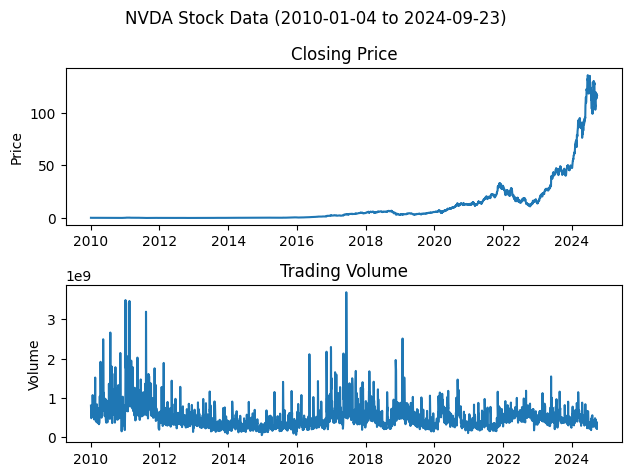

In [98]:
import matplotlib.pyplot as plt

# Create the first panel and set the current axis
plt.subplot(2, 1, 1)  # (rows, columns, panel number)
plt.plot(tickerDF['Close'])
plt.title('Closing Price')  # Add title for the first plot
plt.ylabel('Price')  # Add y-axis label

# Create the second panel and set the current axis
plt.subplot(2, 1, 2)
plt.plot(tickerDF['Volume'])
plt.title('Trading Volume')  # Add title for the second plot
plt.ylabel('Volume')  # Add y-axis label

# Add a main title to the chart
plt.suptitle(f'{symbol} Stock Data ({str(tickerDF.index.min().date())} to {str(tickerDF.index.max().date())})')  # This will add a title at the top of the figure

# Adjust layout to prevent overlap
plt.tight_layout(pad=1.0);